In [22]:
from pathlib import Path
import os, json, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump, load

# sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,   
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Dataset paths ---
LIAR_DIR = Path("data/LIAR_dataset")
NEWS_DIR = Path("data/News_dataset")

print("LIAR dataset path:", LIAR_DIR)
print("News dataset path:", NEWS_DIR)

# --- LIAR split files ---
train_file = LIAR_DIR / "train.tsv"
val_file   = LIAR_DIR / "valid.tsv"
test_file  = LIAR_DIR / "test.tsv"

for f in [train_file, val_file, test_file]:
    assert f.exists(), f"Missing file: {f}"

# --- LIAR loading function ---
def load_liar(path: Path) -> pd.DataFrame:
    """
    Load the LIAR dataset (Kaggle format: first column = id, second = label).
    The file is tab-separated with 14 columns and no header.
    """
    df = pd.read_csv(path, sep="\t", header=None, dtype=str, keep_default_na=False)
    df = df.rename(columns={
        0:"id", 1:"label", 2:"statement", 3:"subject", 4:"speaker", 5:"job_title",
        6:"state_info", 7:"party_affiliation", 8:"barely_true_counts", 9:"false_counts",
        10:"half_true_counts", 11:"mostly_true_counts", 12:"pants_on_fire_counts",
        13:"context"
    })
    return df

# --- Load LIAR splits ---
train_df = load_liar(train_file)
val_df   = load_liar(val_file)
test_df  = load_liar(test_file)

# --- Label mapping (text → numeric id) ---
label_map = {
    "pants-fire": 0,
    "false": 1,
    "barely-true": 2,
    "half-true": 3,
    "mostly-true": 4,
    "true": 5
}

for df in (train_df, val_df, test_df):
    df["label_id"] = df["label"].map(label_map)

print("Shapes → Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)
train_df.head(3)


LIAR dataset path: data\LIAR_dataset
News dataset path: data\News_dataset
Shapes → Train: (10240, 15)  Val: (1284, 15)  Test: (1267, 15)


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_id
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,3
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,4


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'clf__C': 0.5}
Test macro-F1: 0.2418

Classification report (test):
               precision    recall  f1-score   support

           0     0.1634    0.3587    0.2245        92
           1     0.3238    0.2731    0.2963       249
           2     0.2368    0.2123    0.2239       212
           3     0.2704    0.2000    0.2299       265
           4     0.2168    0.2033    0.2099       241
           5     0.2469    0.2885    0.2661       208

    accuracy                         0.2431      1267
   macro avg     0.2430    0.2560    0.2418      1267
weighted avg     0.2535    0.2431    0.2437      1267



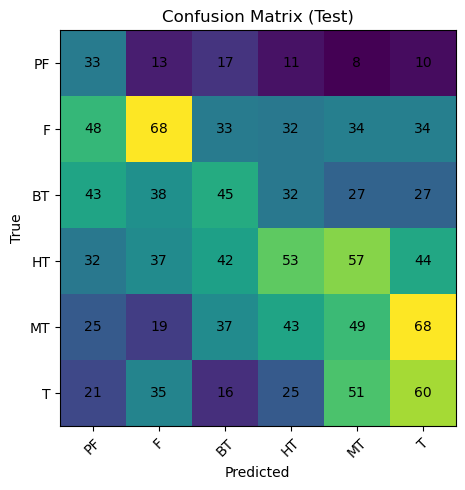

In [23]:
# Features/labels
X_train, y_train = train_df["statement"].tolist(), train_df["label_id"].astype(int).to_numpy()
X_val,   y_val   = val_df["statement"].tolist(),   val_df["label_id"].astype(int).to_numpy()
X_test,  y_test  = test_df["statement"].tolist(),  test_df["label_id"].astype(int).to_numpy()

# TF-IDF + Logistic Regression (simple, reproducible)
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=3000, random_state=42, class_weight="balanced"))
])

grid = GridSearchCV(
    pipe,
    param_grid={"clf__C": [0.5, 1.0, 2.0]},
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

y_test_pred = grid.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average="macro")
print("Best params:", grid.best_params_)
print("Test macro-F1:", round(test_f1, 4))
print("\nClassification report (test):\n", classification_report(y_test, y_test_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


In [17]:
os.makedirs("experiments", exist_ok=True)

dump(grid.best_estimator_, "experiments/liar_logreg_model.joblib")
with open("experiments/liar_logreg_metrics.json", "w") as f:
    json.dump({
        "model": "TFIDF(word 1-2) + LogReg",
        "best_params": grid.best_params_,
        "test_macro_f1": float(test_f1)
    }, f, indent=2)


In [18]:
# TF-IDF(char 3-6) + LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

pipe_char = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,6),
                              min_df=1, max_df=0.95, sublinear_tf=True)),
    ("clf", LinearSVC(random_state=SEED))
])

param_grid_char = {
    "tfidf__ngram_range": [(3,5), (3,6), (4,6)],
    "clf__C": [0.25, 0.5, 1, 2, 4],
    "clf__class_weight": [None, "balanced"],
    "clf__loss": ["squared_hinge", "hinge"],
}

grid_char = GridSearchCV(pipe_char, param_grid_char,
                         scoring="f1_macro", cv=5, n_jobs=-1, verbose=1)
grid_char.fit(X_train, y_train)
y_test_pred_char = grid_char.predict(X_test)
char_f1 = f1_score(y_test, y_test_pred_char, average="macro")
print("Char-only best:", grid_char.best_params_, " Test macro-F1:", round(char_f1, 4))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Char-only best: {'clf__C': 0.25, 'clf__class_weight': 'balanced', 'clf__loss': 'squared_hinge', 'tfidf__ngram_range': (3, 6)}  Test macro-F1: 0.2383


Char-only — Test accuracy: 0.2463 | Test macro-F1: 0.2383

Classification report (char-only):
               precision    recall  f1-score   support

           0     0.1452    0.1957    0.1667        92
           1     0.2928    0.2610    0.2760       249
           2     0.2222    0.1981    0.2095       212
           3     0.2530    0.2377    0.2451       265
           4     0.2576    0.2448    0.2511       241
           5     0.2559    0.3125    0.2814       208

    accuracy                         0.2463      1267
   macro avg     0.2378    0.2416    0.2383      1267
weighted avg     0.2492    0.2463    0.2466      1267



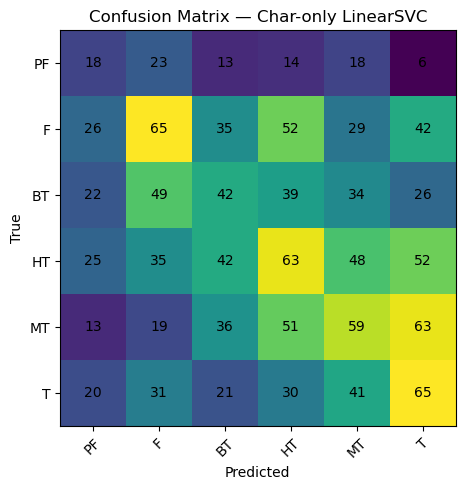

In [20]:
#This should be in written in the previous cell

os.makedirs("experiments", exist_ok=True)

# Evaluate
test_acc_char = accuracy_score(y_test, y_test_pred_char)
print(f"Char-only — Test accuracy: {test_acc_char:.4f} | Test macro-F1: {char_f1:.4f}")
print("\nClassification report (char-only):\n",
      classification_report(y_test, y_test_pred_char, digits=4))

# Confusion matrix
cm_char = confusion_matrix(y_test, y_test_pred_char)
plt.figure(figsize=(6,5))
plt.imshow(cm_char)
plt.title("Confusion Matrix — Char-only LinearSVC")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm_char.shape[0]):
    for j in range(cm_char.shape[1]):
        plt.text(j, i, cm_char[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# Save model + metrics
dump(grid_char.best_estimator_, "experiments/liar_char_svm_model.joblib")
with open("experiments/liar_char_svm_metrics.json", "w") as f:
    json.dump({
        "model": "TFIDF(char 3-6) + LinearSVC",
        "best_params": grid_char.best_params_,
        "test_macro_f1": float(char_f1),
        "test_accuracy": float(test_acc_char)
    }, f, indent=2)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Word+Char+SGD best: {'clf__alpha': 0.001, 'clf__penalty': 'l2', 'vec__char__ngram_range': (3, 5), 'vec__word__ngram_range': (1, 2)}  Test macro-F1: 0.2362
Word+Char+SGD — Test accuracy: 0.2494 | Test macro-F1: 0.2362

Classification report (word+char+SGD):
               precision    recall  f1-score   support

           0     0.1594    0.1196    0.1366        92
           1     0.2874    0.2851    0.2863       249
           2     0.2686    0.2217    0.2429       212
           3     0.2355    0.2604    0.2473       265
           4     0.2548    0.2780    0.2659       241
           5     0.2318    0.2452    0.2383       208

    accuracy                         0.2494      1267
   macro avg     0.2396    0.2350    0.2362      1267
weighted avg     0.2488    0.2494    0.2483      1267



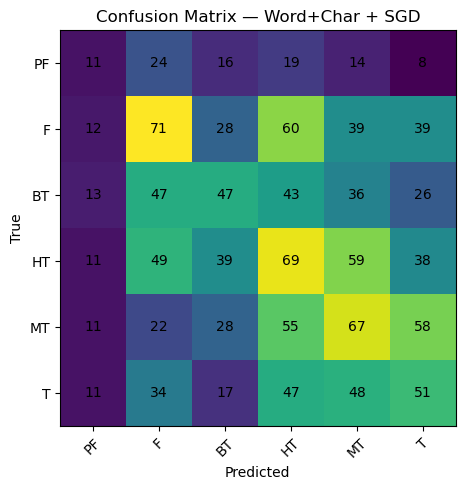

In [24]:
# Word + Char n-grams with SGDClassifier

word_v = TfidfVectorizer(analyzer="word", ngram_range=(1,2),
                         min_df=1, max_df=0.95, sublinear_tf=True)
char_v = TfidfVectorizer(analyzer="char", ngram_range=(3,6),
                         min_df=1, max_df=0.95, sublinear_tf=True)

pipe_wchar_sgd = Pipeline([
    ("vec", FeatureUnion([("word", word_v), ("char", char_v)])),
    ("clf", SGDClassifier(loss="hinge", random_state=SEED))
])

param_grid_wchar_sgd = {
    "vec__word__ngram_range": [(1,1), (1,2)],
    "vec__char__ngram_range": [(3,5), (3,6)],
    "clf__alpha": [1e-5, 1e-4, 1e-3],
    "clf__penalty": ["l2", "elasticnet"],
}

grid_wchar_sgd = GridSearchCV(
    pipe_wchar_sgd, param_grid_wchar_sgd,
    scoring="f1_macro", cv=5, n_jobs=-1, verbose=1
)
grid_wchar_sgd.fit(X_train, y_train)

y_test_pred_wchar_sgd = grid_wchar_sgd.predict(X_test)
wchar_sgd_f1 = f1_score(y_test, y_test_pred_wchar_sgd, average="macro")
print("Word+Char+SGD best:", grid_wchar_sgd.best_params_,
      " Test macro-F1:", round(wchar_sgd_f1, 4))

# --- Evaluate ---
test_acc_wchar_sgd = accuracy_score(y_test, y_test_pred_wchar_sgd)
print(f"Word+Char+SGD — Test accuracy: {test_acc_wchar_sgd:.4f} | Test macro-F1: {wchar_sgd_f1:.4f}")
print("\nClassification report (word+char+SGD):\n",
      classification_report(y_test, y_test_pred_wchar_sgd, digits=4))

# --- Confusion matrix ---
cm_wchar_sgd = confusion_matrix(y_test, y_test_pred_wchar_sgd)
plt.figure(figsize=(6,5))
plt.imshow(cm_wchar_sgd)  # default colormap; no custom colors
plt.title("Confusion Matrix — Word+Char + SGD")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm_wchar_sgd.shape[0]):
    for j in range(cm_wchar_sgd.shape[1]):
        plt.text(j, i, cm_wchar_sgd[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


os.makedirs("experiments", exist_ok=True)
dump(grid_wchar_sgd.best_estimator_, "experiments/liar_wordchar_sgd_model.joblib")
with open("experiments/liar_wordchar_sgd_metrics.json", "w") as f:
    json.dump({
        "model": "TFIDF(word 1-2 + char 3-6) + SGD(hinge)",
        "best_params": grid_wchar_sgd.best_params_,
        "test_macro_f1": float(wchar_sgd_f1),
        "test_accuracy": float(test_acc_wchar_sgd)
    }, f, indent=2)


In [28]:
# The next two cells are addressing the project proposal's feedback


# === Robustness check: Drop the last sentence from every claim (train and test) ===
# Idea: Some LIAR examples (e.g., “never…”) get their label from a dramatic final line.
# We remove the final sentence from ALL statements (both training and testing) and
# re-train/evaluate the baseline to see how much performance drops.
# Interpretation:
#   - Tiny Δ macro-F1 → model is NOT overly reliant on last-sentence cues.
#   - Large Δ → model depends heavily on the final sentence wording.
# This directly answers the feedback about task reasonableness and shortcut learning.

import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def drop_last_sentence(text: str) -> str:
    parts = re.split(r'([.!?])', text)
    if len(parts) >= 2: parts = parts[:-2]
    return "".join(parts).strip() if parts else text

X_train_drop = [drop_last_sentence(t) for t in train_df["statement"]]
X_test_drop  = [drop_last_sentence(t) for t in test_df["statement"]]

pipe_ab = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=3000, random_state=SEED, class_weight="balanced", C=0.5))
])
pipe_ab.fit(X_train_drop, y_train)
ab_pred = pipe_ab.predict(X_test_drop)
ab_f1 = f1_score(y_test, ab_pred, average="macro")
print("Drop-last-sentence — Test macro-F1:", round(ab_f1, 4), " (baseline:", round(test_f1, 4), ")")


Drop-last-sentence — Test macro-F1: 0.2379  (baseline: 0.2418 )


In [29]:
# === Artifact check: metadata-only baseline (no statement text) ===
# Idea: If this scores non-trivially, models can exploit speaker/party/state shortcuts.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from joblib import dump
import os, json

META_COLS = ["speaker","party_affiliation","state_info","subject","job_title","context"]

def meta_text(df):
    return (df[META_COLS].fillna("").astype(str).agg(" ".join, axis=1)).tolist()

Xm_train, Xm_test = meta_text(train_df), meta_text(test_df)

meta_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=3000, random_state=SEED, class_weight="balanced", C=1.0))
])

meta_pipe.fit(Xm_train, y_train)
meta_pred = meta_pipe.predict(Xm_test)
meta_f1 = f1_score(y_test, meta_pred, average="macro")
meta_acc = accuracy_score(y_test, meta_pred)
print(f"Metadata-only — Test accuracy: {meta_acc:.4f} | Test macro-F1: {meta_f1:.4f}")
print("\nClassification report (metadata-only):\n", classification_report(y_test, meta_pred, digits=4))

# Save
os.makedirs("experiments", exist_ok=True)
dump(meta_pipe, "experiments/liar_metadata_only_model.joblib")
with open("experiments/liar_metadata_only_metrics.json","w") as f:
    json.dump({"model":"metadata_only","macro_f1":float(meta_f1),"accuracy":float(meta_acc)}, f, indent=2)


Metadata-only — Test accuracy: 0.2518 | Test macro-F1: 0.2541

Classification report (metadata-only):
               precision    recall  f1-score   support

           0     0.2387    0.4022    0.2996        92
           1     0.2632    0.2209    0.2402       249
           2     0.2128    0.1887    0.2000       212
           3     0.2836    0.2151    0.2446       265
           4     0.2870    0.2573    0.2713       241
           5     0.2282    0.3269    0.2688       208

    accuracy                         0.2518      1267
   macro avg     0.2522    0.2685    0.2541      1267
weighted avg     0.2560    0.2518    0.2493      1267



In [33]:
# Summary 

rows = [
    ("TFIDF(word 1-2) + LogReg", float(test_f1), float(accuracy_score(y_test, y_test_pred))),
    ("TFIDF(char 3-6) + LinearSVC", float(char_f1), float(accuracy_score(y_test, y_test_pred_char))),
    ("TFIDF(word 1-2 + char 3-6) + SGD(hinge)", float(wchar_sgd_f1), float(accuracy_score(y_test, y_test_pred_wchar_sgd))),
    ("Metadata-only", float(meta_f1), float(meta_acc)),
]
summary = pd.DataFrame(rows, columns=["model","macro_f1","accuracy"]).sort_values("macro_f1", ascending=False)
display(summary)

os.makedirs("experiments", exist_ok=True)
summary.to_csv("experiments/liar_models_summary.csv", index=False)

best_model_name = summary.iloc[0]["model"]
best_preds = {
    "TFIDF(word 1-2) + LogReg": y_test_pred,
    "TFIDF(char 3-6) + LinearSVC": y_test_pred_char,
    "TFIDF(word 1-2 + char 3-6) + SGD(hinge)": y_test_pred_wchar_sgd,
    "Metadata-only": meta_pred,
}[best_model_name]
print("Best by macro-F1:", best_model_name)

os.makedirs("experiments", exist_ok=True)

with open("experiments/label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

liar_stats = {
    "train_shape": list(train_df.shape),
    "val_shape": list(val_df.shape),
    "test_shape": list(test_df.shape),
    "train_label_counts": train_df["label"].value_counts().to_dict(),
    "val_label_counts": val_df["label"].value_counts().to_dict(),
    "test_label_counts": test_df["label"].value_counts().to_dict(),
}
with open("experiments/liar_dataset_stats.json","w") as f:
    json.dump(liar_stats, f, indent=2)


,model,macro_f1,accuracy
3,Metadata-only,0.254086,0.251776
0,TFIDF(word 1-2) + LogReg,0.241755,0.243094
1,TFIDF(char 3-6) + LinearSVC,0.238289,0.246251
2,TFIDF(word 1-2 + char 3-6) + SGD(hinge),0.236222,0.249408


Best by macro-F1: Metadata-only
